Total rows in public dataset before sampling: 177482
Total rows in public dataset after sampling: 5000
Class distribution in sampled public dataset:
Class
Trojan    74
Benign    71
Name: count, dtype: int64
PCAP Data - Total Rows After Removal: 382
                         Flow ID    Src IP Src Port    Dst IP Dst Port  \
3  10.0.0.3-10.0.0.4-49908-443-6  10.0.0.3    49908  10.0.0.4      443   
6  10.0.0.3-10.0.0.4-49911-443-6  10.0.0.3    49911  10.0.0.4      443   
7  10.0.0.3-10.0.0.4-49912-443-6  10.0.0.3    49912  10.0.0.4      443   
8  10.0.0.4-10.0.0.3-443-49912-6  10.0.0.4      443  10.0.0.3    49912   
9  10.0.0.3-10.0.0.4-49913-443-6  10.0.0.3    49913  10.0.0.4      443   

  Protocol               Timestamp Flow Duration Tot Fwd Pkts Tot Bwd Pkts  \
3        6  08/10/2024 02:44:59 AM        310246            5            3   
6        6  08/10/2024 02:45:00 AM         66065            5            4   
7        6  08/10/2024 02:45:01 AM         15861            5           

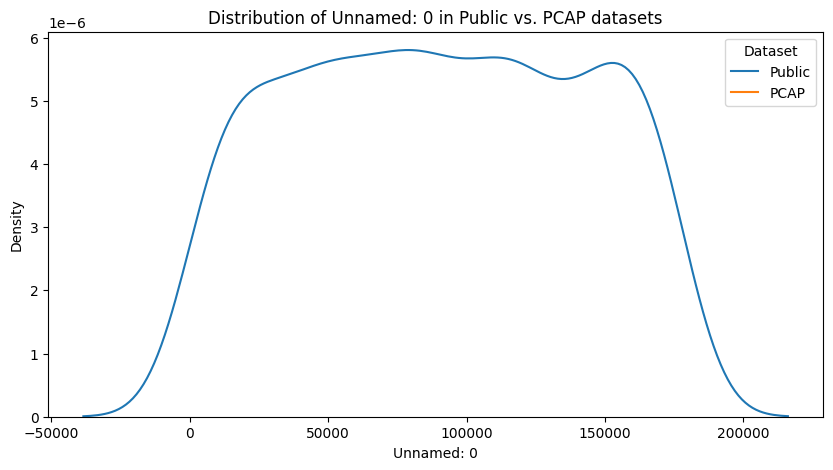

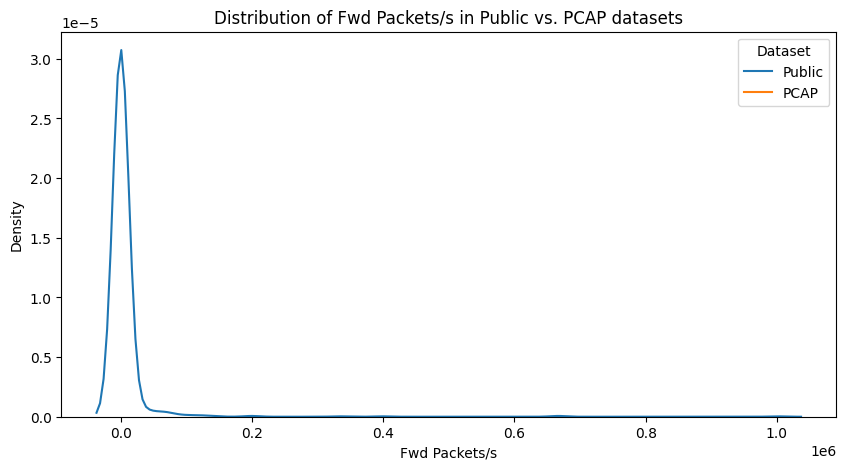

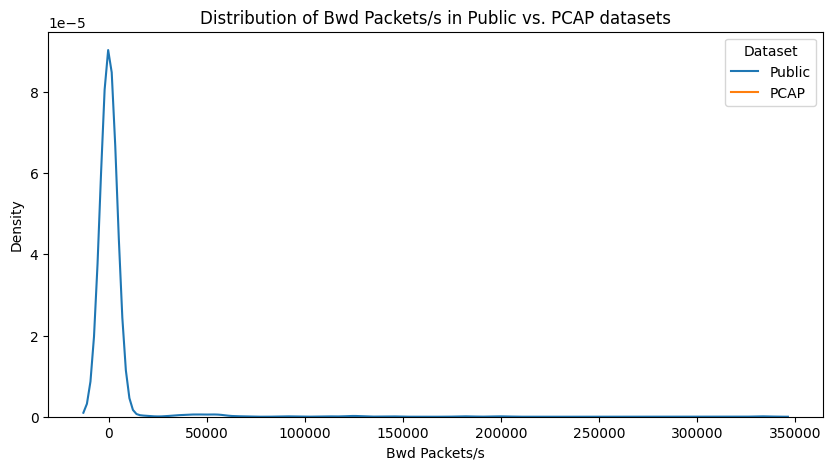

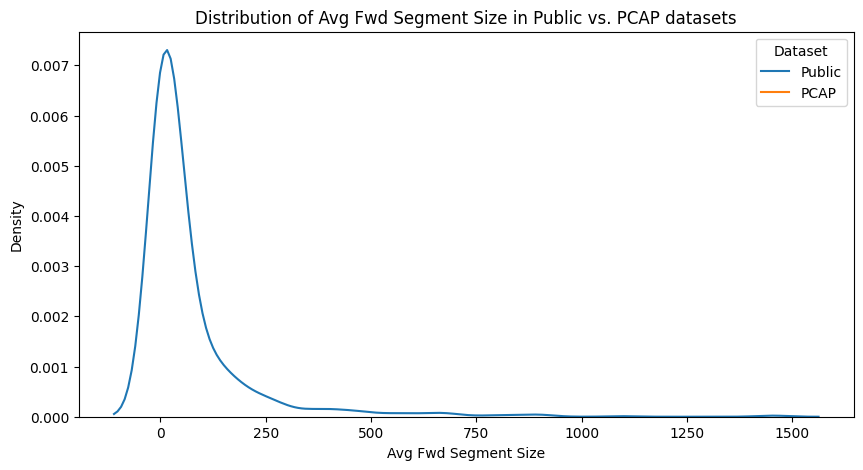

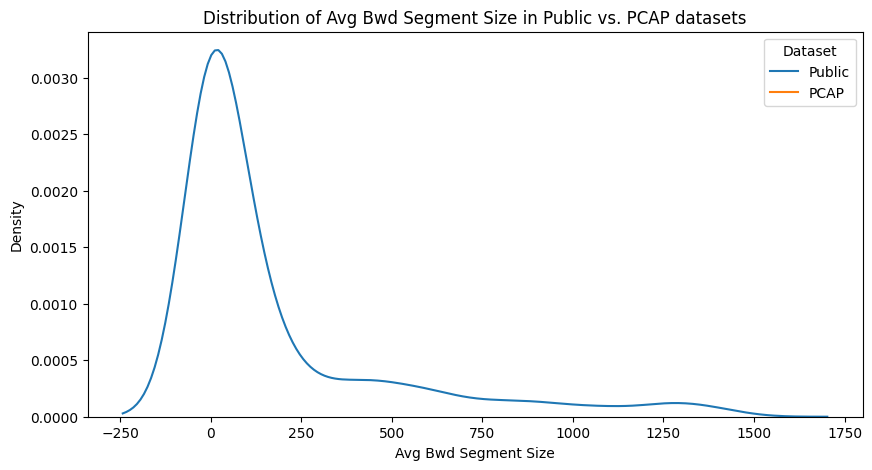


Preparing training data...

Checking for infinite values in X_combined_numeric...
All infinite values have been replaced with NaN.

Percentage of missing values per column:
Source Port          0.01858
Destination Port     0.01858
Protocol             0.01858
Flow Duration        0.01858
Total Fwd Packets    0.01858
                      ...   
Active Min           0.01858
Idle Mean            0.01858
Idle Std             0.01858
Idle Max             0.01858
Idle Min             0.01858
Length: 80, dtype: float64
No NaN values present after imputation.
Combined data imputed and scaled successfully.

Handling class imbalance with SMOTE...
Original class distribution:
Class
0    5308
1      74
Name: count, dtype: int64
Class distribution after resampling:
Class
0    5308
1    5308
Name: count, dtype: int64

Splitting data into training and test sets...

Applying feature selection...
Selected features: ['Destination Port', 'Flow Duration', 'Fwd Packet Length Max', 'Fwd Packet Length Mean

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Model Selection and Evaluation
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    f1_score
)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from imblearn.over_sampling import SMOTE

# Handle warnings
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load the public dataset and PCAP data
public_data_path = "/home/ubuntu/Downloads/Trojan_Detection.csv"
pcap_data_path = "/home/ubuntu/Downloads/Beforemalware.pcap_ISCX.csv"

public_df = pd.read_csv(public_data_path)
pcap_df = pd.read_csv(pcap_data_path)


# Step 1a: Sample 5,000 rows from the public dataset
print(f"Total rows in public dataset before sampling: {len(public_df)}")
if len(public_df) > 5000:
    # Stratified sampling using train_test_split
    X_public = public_df.drop(columns=["Class"], errors='ignore')
    y_public = public_df["Class"]

    X_public_sample, _, y_public_sample, _ = train_test_split(
        X_public, y_public,
        train_size=5000,
        stratify=y_public,
        random_state=42
    )

    public_df = X_public_sample.copy()
    public_df['Class'] = y_public_sample.reset_index(drop=True)
print(f"Total rows in public dataset after sampling: {len(public_df)}")
print("Class distribution in sampled public dataset:")
print(public_df['Class'].value_counts())

# Step 2: Identify and Remove Duplicate Flow IDs in PCAP Data
duplicate_flow_ids = pcap_df[pcap_df.duplicated(subset='Flow ID', keep=False)]['Flow ID'].unique()
pcap_df = pcap_df[~pcap_df['Flow ID'].isin(duplicate_flow_ids)]

# Inspect the cleaned PCAP data (optional)
print(f"PCAP Data - Total Rows After Removal: {len(pcap_df)}")
print(pcap_df.head())

# Expected column names
expected_columns = [
    'Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 
    'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packets', 
    'Total Backward Packets', 'Total Length of Fwd Packets', 
    'Total Length of Bwd Packets', 'Fwd Packet Length Max', 
    'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 
    'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 
    'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 
    'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 
    'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 
    'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 
    'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 
    'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 
    'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 
    'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 
    'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 
    'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 
    'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size', 
    'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 
    'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 
    'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 
    'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 
    'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd', 
    'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 
    'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Class'
]

# Column mapping to handle slight naming differences
column_mapping = {
    'Src IP': 'Source IP',
    'Dst IP': 'Destination IP',
    'Src Port': 'Source Port',
    'Dst Port': 'Destination Port',
    'Tot Fwd Pkts': 'Total Fwd Packets',
    'Tot Bwd Pkts': 'Total Backward Packets',
    'TotLen Fwd Pkts': 'Total Length of Fwd Packets',
    'TotLen Bwd Pkts': 'Total Length of Bwd Packets',
    'Fwd Pkt Len Max': 'Fwd Packet Length Max',
    'Fwd Pkt Len Min': 'Fwd Packet Length Min',
    'Fwd Pkt Len Mean': 'Fwd Packet Length Mean',
    'Fwd Pkt Len Std': 'Fwd Packet Length Std',
    'Bwd Pkt Len Max': 'Bwd Packet Length Max',
    'Bwd Pkt Len Min': 'Bwd Packet Length Min',
    'Bwd Pkt Len Mean': 'Bwd Packet Length Mean',
    'Bwd Pkt Len Std': 'Bwd Packet Length Std',
    'Flow Byts/s': 'Flow Bytes/s',
    'Flow Pkts/s': 'Flow Packets/s',
    'Fwd IAT Tot': 'Fwd IAT Total',
    'Bwd IAT Tot': 'Bwd IAT Total',
    'Fwd Header Len': 'Fwd Header Length',
    'Bwd Header Len': 'Bwd Header Length',
    'Pkt Len Min': 'Min Packet Length',
    'Pkt Len Max': 'Max Packet Length',
    'Pkt Len Mean': 'Packet Length Mean',
    'Pkt Len Std': 'Packet Length Std',
    'Pkt Len Var': 'Packet Length Variance',
    'FIN Flag Cnt': 'FIN Flag Count',
    'SYN Flag Cnt': 'SYN Flag Count',
    'RST Flag Cnt': 'RST Flag Count',
    'PSH Flag Cnt': 'PSH Flag Count',
    'ACK Flag Cnt': 'ACK Flag Count',
    'URG Flag Cnt': 'URG Flag Count',
    'Init Fwd Win Byts': 'Init_Win_bytes_forward',
    'Init Bwd Win Byts': 'Init_Win_bytes_backward',
    'Fwd Act Data Pkts': 'act_data_pkt_fwd',
    'Fwd Seg Size Min': 'min_seg_size_forward',
    'Pkt Size Avg': 'Average Packet Size'
}

# Apply the column mapping
pcap_df.rename(columns=column_mapping, inplace=True)

# Add missing columns with NaN values
for col in expected_columns:
    if col not in pcap_df.columns:
        pcap_df[col] = pd.NA

# Ensure columns are in the correct order
pcap_df = pcap_df[expected_columns]

# Verify the alignment
print(f"Aligned PCAP Columns:\n{pcap_df.columns}")
print(f"Number of Columns: {len(pcap_df.columns)}")

# Step 2: Align column names between datasets
public_df.columns = public_df.columns.str.strip()
pcap_df.columns = pcap_df.columns.str.strip()

# Check for differences in column names
missing_in_public = set(pcap_df.columns) - set(public_df.columns)
missing_in_pcap = set(public_df.columns) - set(pcap_df.columns)
print(f"Missing in public dataset: {missing_in_public}")
print(f"Missing in PCAP dataset: {missing_in_pcap}")

# Use only common columns for consistency
common_columns = public_df.columns.intersection(pcap_df.columns).tolist()

# Step 3: EDA - Compare feature distributions
print("\nStarting Exploratory Data Analysis (EDA)...")

# Combine datasets for comparison
public_df['Dataset'] = 'Public'
pcap_df['Dataset'] = 'PCAP'

# Determine sample sizes based on available data
public_sample_size = min(1000, len(public_df))
pcap_sample_size = min(1000, len(pcap_df))

# Sample datasets if they are large to speed up plotting
public_sample = public_df.sample(n=public_sample_size, random_state=42)
pcap_sample = pcap_df.sample(n=pcap_sample_size, random_state=42)

# Combine datasets for comparison
combined_df = pd.concat([public_sample, pcap_sample], ignore_index=True)

# Select numeric columns
numeric_features = combined_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Class', 'Dataset']]

# Plot distributions for a few key features
for feature in numeric_features[:5]:  # Adjust the number of features as needed
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=combined_df, x=feature, hue='Dataset', common_norm=False)
    plt.title(f'Distribution of {feature} in Public vs. PCAP datasets')
    plt.show()

# Step 4: Prepare training data
print("\nPreparing training data...")

# Extract features and labels from the public dataset
X_public = public_df[common_columns].drop(columns=["Class", "Dataset"], errors='ignore')
y_public = public_df["Class"].apply(lambda x: 1 if x == "Trojan" else 0)

# Label your PCAP data as benign
pcap_df['Class'] = 0  # Since you know your data is benign

X_pcap = pcap_df[common_columns].drop(columns=["Class", "Dataset"], errors='ignore')
y_pcap = pcap_df['Class']

# Combine datasets
X_combined = pd.concat([X_public, X_pcap], ignore_index=True)
y_combined = pd.concat([y_public, y_pcap], ignore_index=True)

# Ensure only numeric data is used for training
X_combined_numeric = X_combined.apply(pd.to_numeric, errors='coerce')

# Drop any remaining columns with all NaN values
X_combined_numeric = X_combined_numeric.dropna(axis=1, how='all')

# **Check and replace infinite values**
print("\nChecking for infinite values in X_combined_numeric...")
# Replace infinite values with NaN
X_combined_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

# Verify that infinite values have been handled
if np.isinf(X_combined_numeric.values).any():
    print("There are still infinite values present.")
else:
    print("All infinite values have been replaced with NaN.")

# Optionally, check the percentage of missing values
missing_percentages = X_combined_numeric.isnull().mean() * 100
print("\nPercentage of missing values per column:")
print(missing_percentages)

# Optionally drop columns with too many missing values
threshold = 50  # Adjust threshold as needed
cols_to_drop = missing_percentages[missing_percentages > threshold].index
if len(cols_to_drop) > 0:
    print(f"Dropping columns with more than {threshold}% missing values: {list(cols_to_drop)}")
    X_combined_numeric.drop(columns=cols_to_drop, inplace=True)

# Update train_columns after preprocessing X_combined
train_columns = X_combined_numeric.columns.tolist()

# Handle missing values with SimpleImputer
imputer = SimpleImputer(strategy="mean")
X_combined_imputed = imputer.fit_transform(X_combined_numeric)

# Check for NaN values after imputation
if np.isnan(X_combined_imputed).any():
    print("Warning: There are still NaN values after imputation.")
else:
    print("No NaN values present after imputation.")

# Scale the imputed data with StandardScaler
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined_imputed)

print("Combined data imputed and scaled successfully.")


# Step 5: Handle class imbalance with SMOTE
print("\nHandling class imbalance with SMOTE...")
print("Original class distribution:")
print(y_combined.value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined_scaled, y_combined)

print("Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts())

# Step 6: Split data into training and test sets
print("\nSplitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# # Step 7: Hyperparameter tuning with GridSearchCV
# print("\nStarting hyperparameter tuning with GridSearchCV...")
# # param_grid = {
# #     'n_estimators': [100, 200],
# #     'max_depth': [None, 10, 20],
# #     'min_samples_split': [2, 5],
# #     'min_samples_leaf': [1, 2],
# #     'class_weight': [None, 'balanced']
# # }

# param_grid = {
#     'n_estimators': [100],  # Try a single value
#     'max_depth': [None, 10],
#     'class_weight': [None, 'balanced']
# }


# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=42),
#     param_grid=param_grid,
#     cv=3,
#     scoring='f1',
#     n_jobs=1,  # Use only one CPU core
#     verbose=2  # Optional: Increase verbosity
# )
# grid_search.fit(X_train, y_train)

# print(f"Best parameters: {grid_search.best_params_}")

# # Use the best estimator
# rf_model = grid_search.best_estimator_

# Step 8: Feature Selection
print("\nApplying feature selection...")
selector = SelectKBest(f_classif, k=20)  # Select top 20 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_feature_indices = selector.get_support(indices=True)
selected_features = [train_columns[i] for i in selected_feature_indices]

print(f"Selected features: {selected_features}")

# Prepare a dictionary to store models and their performance
models_performance = {}

# Function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\nTraining and evaluating {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # For models like SVM without predict_proba, use decision_function
        y_proba = model.decision_function(X_test)
        # For binary classification, convert to probability using logistic function
        from scipy.special import expit
        y_proba = expit(y_proba)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(confusion)

    # Store performance
    models_performance[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'classification_report': report,
        'confusion_matrix': confusion,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# Step 8: Train and evaluate KNN
print("\nTraining and evaluating KNN...")
knn_params = {
    'n_neighbors': 5,
    'weights': 'uniform',
    'algorithm': 'auto'
}
knn_model = KNeighborsClassifier(**knn_params)
evaluate_model("KNN", knn_model, X_train_selected, y_train, X_test_selected, y_test)

# Step 9: Train and evaluate Random Forest
print("\nTraining and evaluating Random Forest...")
rf_params = {
    'n_estimators': 100,
    'max_depth': None,
    'class_weight': 'balanced',
    'random_state': 42
}
rf_model = RandomForestClassifier(**rf_params)
evaluate_model("Random Forest", rf_model, X_train_selected, y_train, X_test_selected, y_test)

# Step 10: Train and evaluate Decision Tree
print("\nTraining and evaluating Decision Tree...")
dt_params = {
    'max_depth': None,
    'class_weight': 'balanced',
    'random_state': 42
}
dt_model = DecisionTreeClassifier(**dt_params)
evaluate_model("Decision Tree", dt_model, X_train_selected, y_train, X_test_selected, y_test)

# Step 11: Train and evaluate SVM
print("\nTraining and evaluating SVM...")
svm_params = {
    'kernel': 'linear',
    'class_weight': 'balanced',
    'probability': True,
    'random_state': 42
}
svm_model = SVC(**svm_params)
evaluate_model("SVM", svm_model, X_train_selected, y_train, X_test_selected, y_test)

# Step 12: Use Isolation Forest for anomaly detection
print("\nTraining and evaluating Isolation Forest...")
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(X_train_selected)

# Predict anomalies (-1 for anomalies, 1 for normal points)
y_pred_iso = iso_forest.predict(X_test_selected)
y_pred_iso_converted = np.where(y_pred_iso == -1, 1, 0)  # Anomalies as 'Trojan'

# Evaluate Isolation Forest
accuracy_iso = accuracy_score(y_test, y_pred_iso_converted)
report_iso = classification_report(y_test, y_pred_iso_converted)
confusion_iso = confusion_matrix(y_test, y_pred_iso_converted)

print(f"Accuracy: {accuracy_iso:.4f}")
print("Classification Report:")
print(report_iso)
print("Confusion Matrix:")
print(confusion_iso)

# Store Isolation Forest performance
models_performance["Isolation Forest"] = {
    'model': iso_forest,
    'accuracy': accuracy_iso,
    'roc_auc': None,  # Not applicable
    'classification_report': report_iso,
    'confusion_matrix': confusion_iso,
    'y_pred': y_pred_iso_converted,
    'y_proba': None  # No probability output for Isolation Forest
}

# Step 13: Compare model performances
print("\nComparing model performances:")
for name, perf in models_performance.items():
    print(f"{name} - Accuracy: {perf['accuracy']:.4f}, ROC AUC: {perf['roc_auc'] if perf['roc_auc'] else 'N/A'}")

# Step 14: Select the best model based on accuracy
best_model_name = max(models_performance, key=lambda x: models_performance[x]['accuracy'])
best_model = models_performance[best_model_name]['model']

print(f"\nBest model selected: {best_model_name}")

# Compute optimal threshold (for models with probability estimates)
if hasattr(best_model, "predict_proba"):
    y_proba_best = best_model.predict_proba(X_test_selected)[:, 1]
else:
    y_scores_best = best_model.decision_function(X_test_selected)
    from scipy.special import expit
    y_proba_best = expit(y_scores_best)

fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold for {best_model_name}: {optimal_threshold}")

# Step 15: Use the best model to predict on PCAP data
print(f"\nPreparing PCAP data for prediction using {best_model_name}...")

# Convert PCAP data to numeric and handle missing values
X_pcap_numeric = X_pcap.apply(pd.to_numeric, errors='coerce')[train_columns]
X_pcap_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_pcap_imputed = imputer.transform(X_pcap_numeric)
X_pcap_scaled = scaler.transform(X_pcap_imputed)
X_pcap_selected = selector.transform(X_pcap_scaled)

# Predict using the best model
if best_model_name == "Isolation Forest":
    y_pcap_pred = best_model.predict(X_pcap_selected)
    y_pcap_pred = np.where(y_pcap_pred == -1, 1, 0)  # Convert -1 to Trojan
else:
    if hasattr(best_model, "predict_proba"):
        y_pcap_proba = best_model.predict_proba(X_pcap_selected)[:, 1]
    else:
        y_scores = best_model.decision_function(X_pcap_selected)
        y_pcap_proba = expit(y_scores)

    # Use the optimal threshold for prediction
    y_pcap_pred = (y_pcap_proba >= optimal_threshold).astype(int)

# Add predictions to the PCAP DataFrame
pcap_df['Predicted Label'] = y_pcap_pred
pcap_df['Predicted Label'] = pcap_df['Predicted Label'].apply(lambda x: 'Trojan' if x == 1 else 'Benign')
pcap_df = pcap_df.drop(columns=['Dataset'], errors='ignore')

# Save predictions to a CSV file
pcap_df.to_csv('beforeMalware_predictions.csv', index=False)
print("\nPredictions saved as 'beforeMalware_predictions.csv'.")

# Display a summary of the predictions
print("\nPrediction Summary:")
print(pcap_df['Predicted Label'].value_counts())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Loading and preprocessing malware data...
Malware Data - Total Rows After Removal: 102
                          Flow ID    Src IP Src Port    Dst IP Dst Port  \
6   10.0.0.3-10.0.0.4-49830-443-6  10.0.0.3    49830  10.0.0.4      443   
13  10.0.0.3-10.0.0.4-49834-443-6  10.0.0.3    49834  10.0.0.4      443   
17  10.0.0.4-10.0.0.3-443-49837-6  10.0.0.4      443  10.0.0.3    49837   
21  10.0.0.4-10.0.0.3-443-49840-6  10.0.0.4      443  10.0.0.3    49840   
25  10.0.0.4-10.0.0.3-443-49842-6  10.0.0.4      443  10.0.0.3    49842   

   Protocol               Timestamp Flow Duration Tot Fwd Pkts Tot Bwd Pkts  \
6         6  14/10/2024 12:50:26 AM        103775            5            3   
13        6  14/10/2024 12:50:26 AM        123213            5            3   
17        6  14/10/2024 12:50:27 AM           585            2            0   
21        6  14/10/2024 12:50:27 AM           580            2            0   
25        6  14/10/2024 12:51:03 AM           236            2    

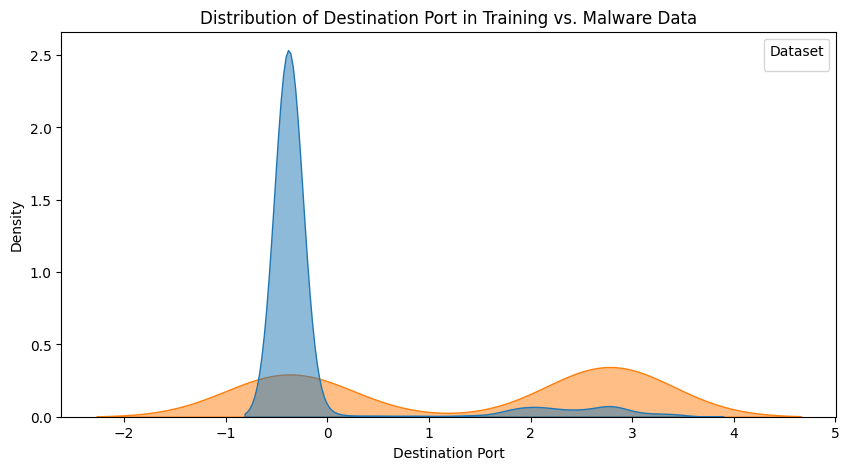

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


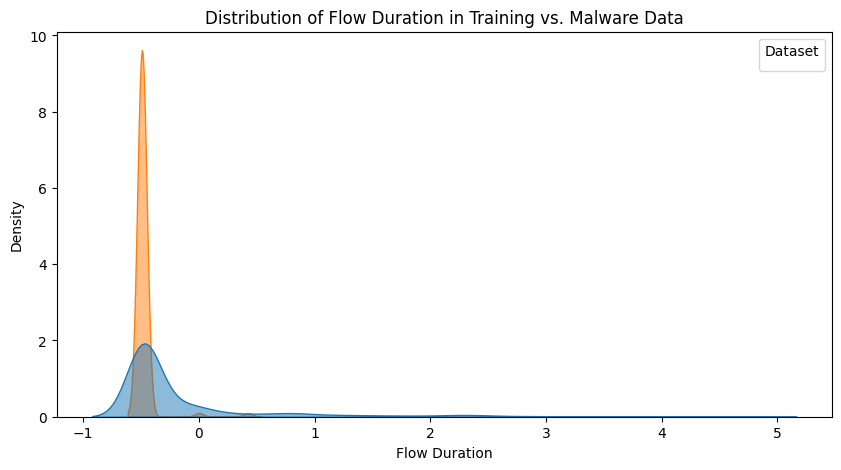

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


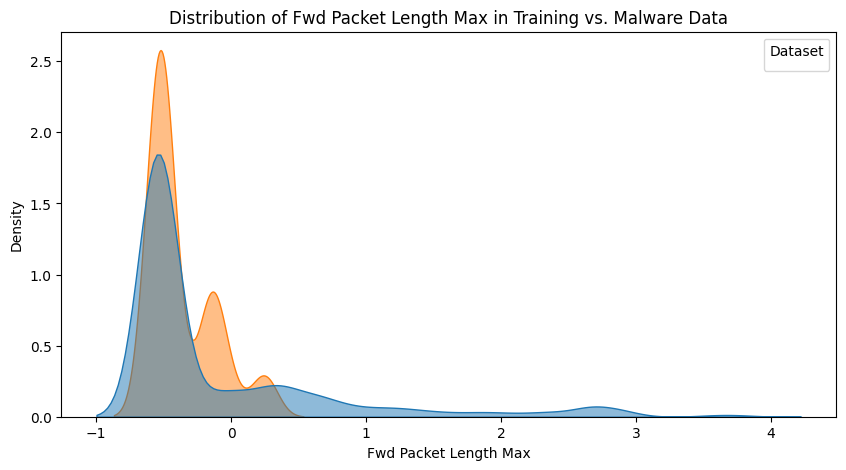

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


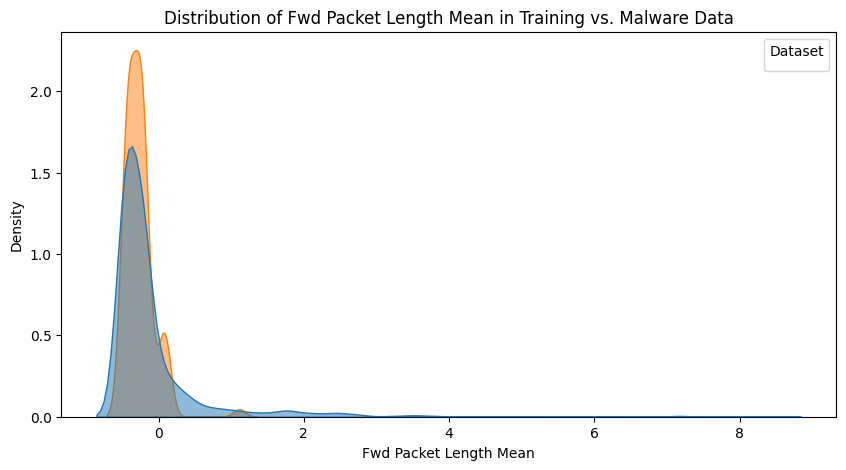

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


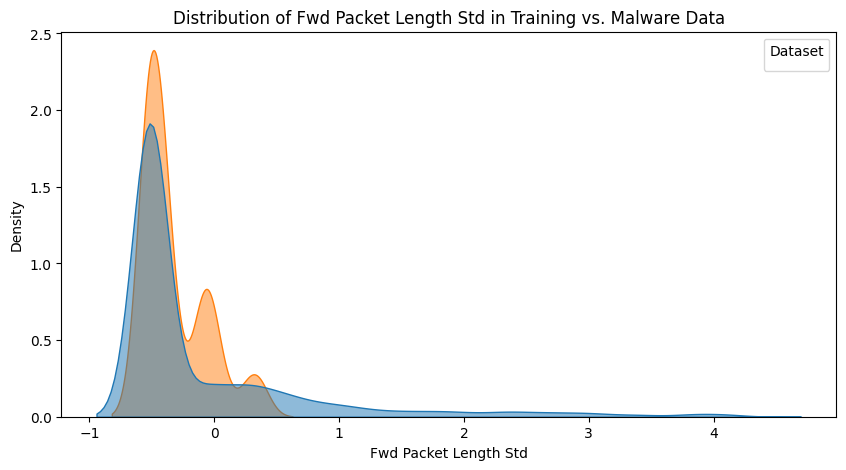

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


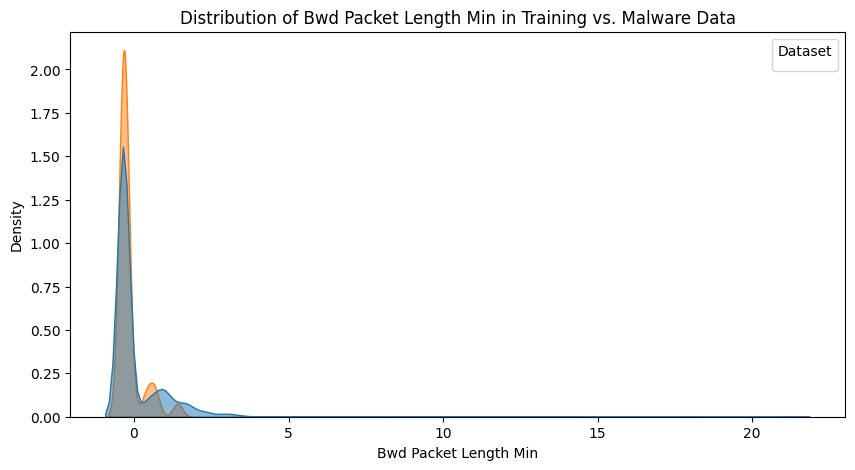

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


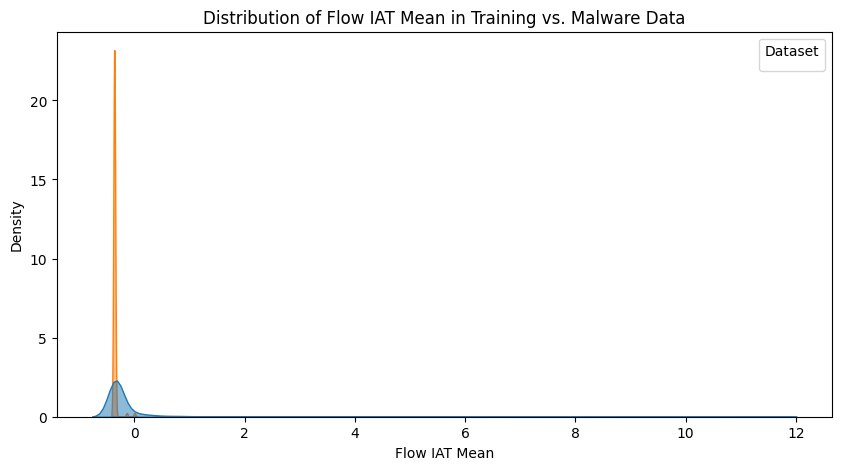

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


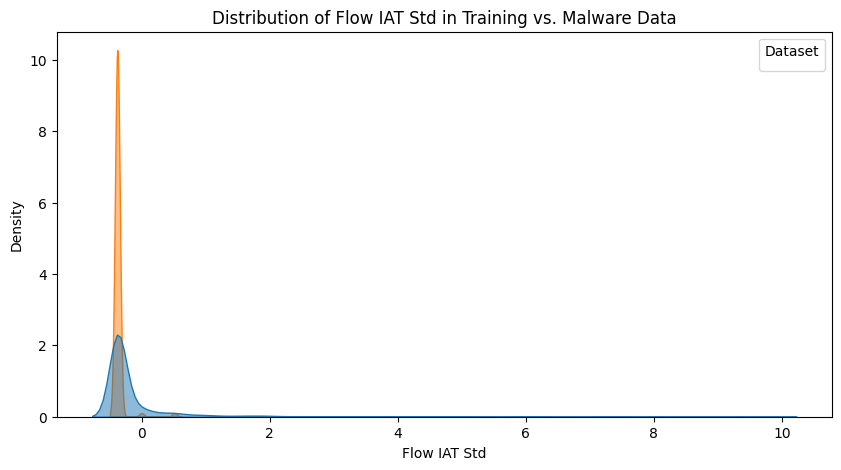

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


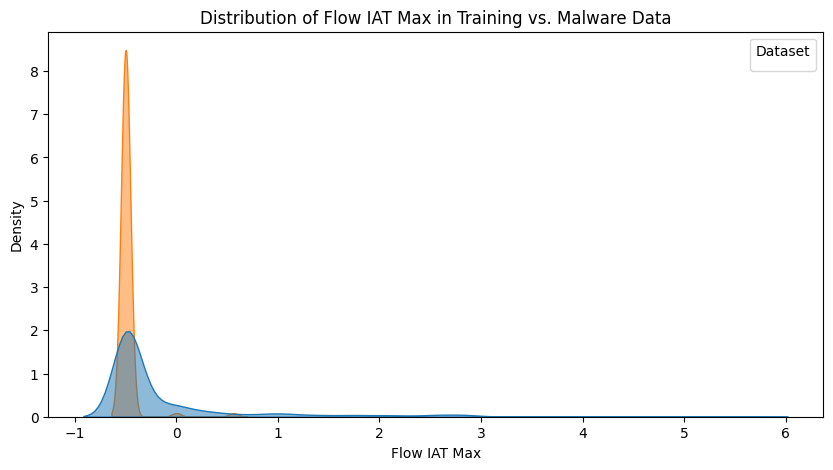

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


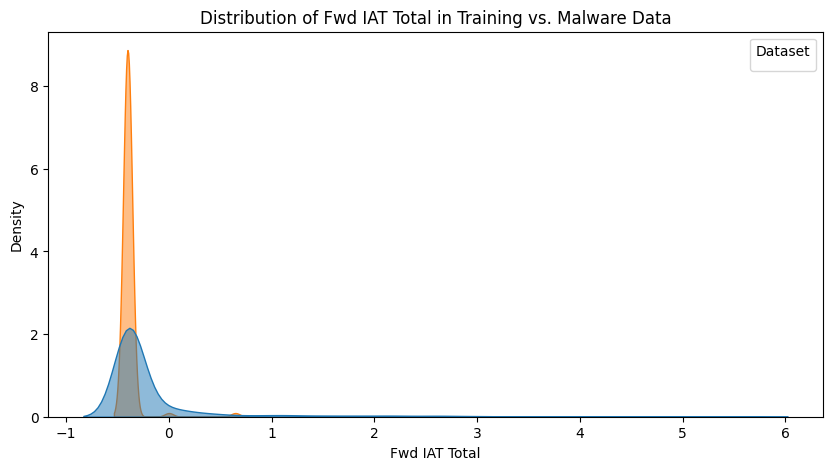

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


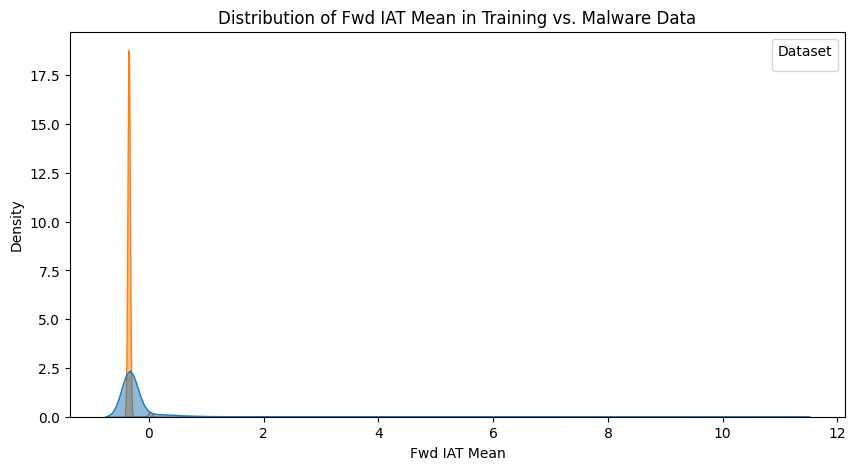

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


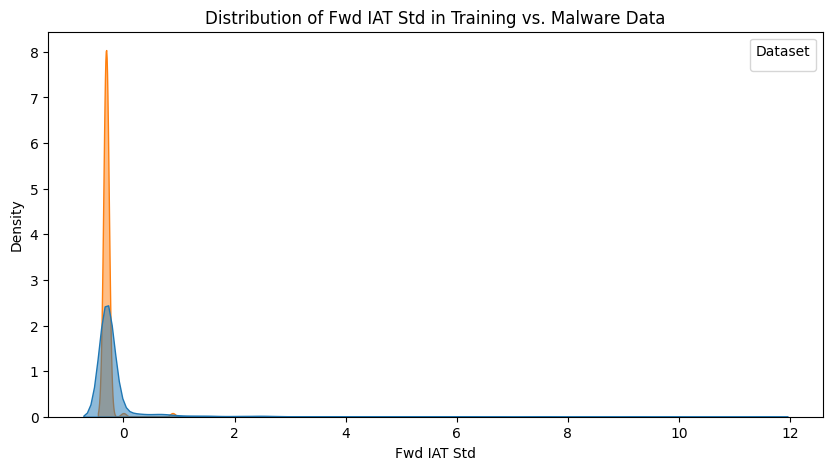

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


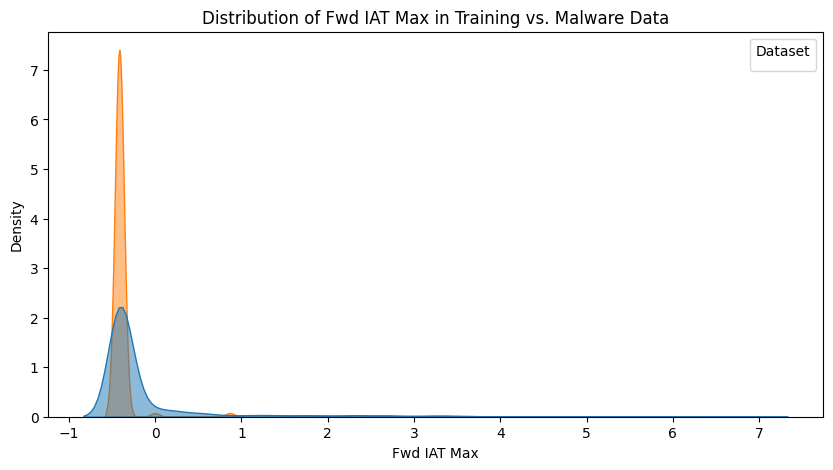

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


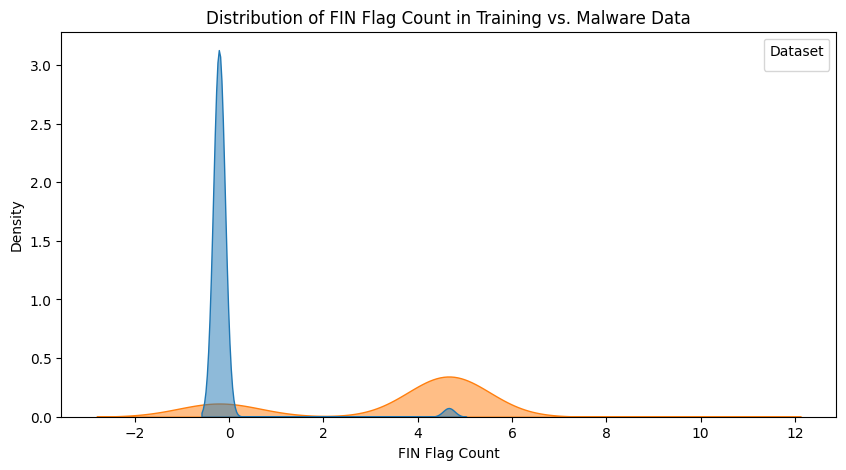

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


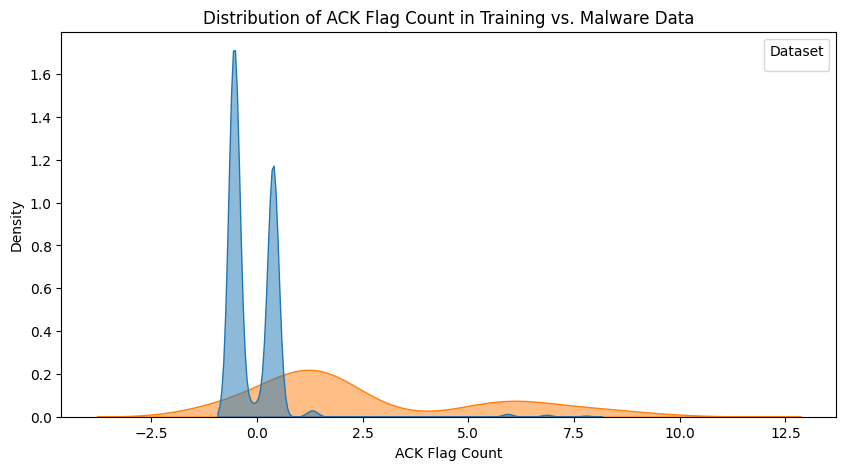

/tmp/ipykernel_38288/1080891914.py:91: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


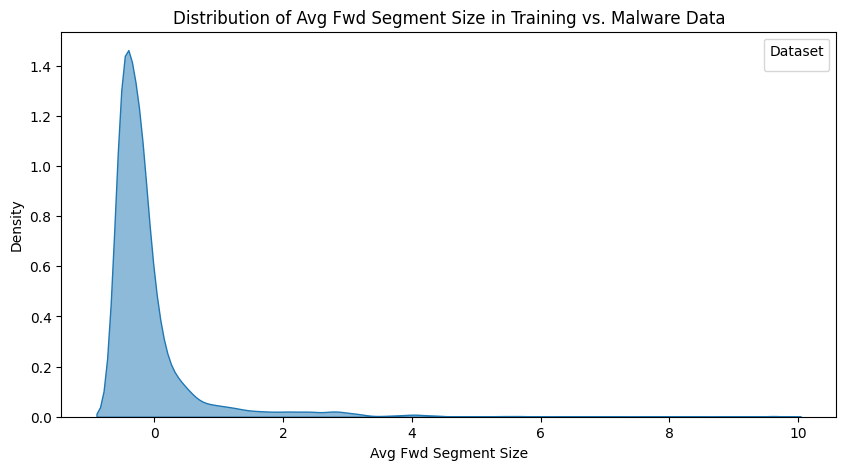

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


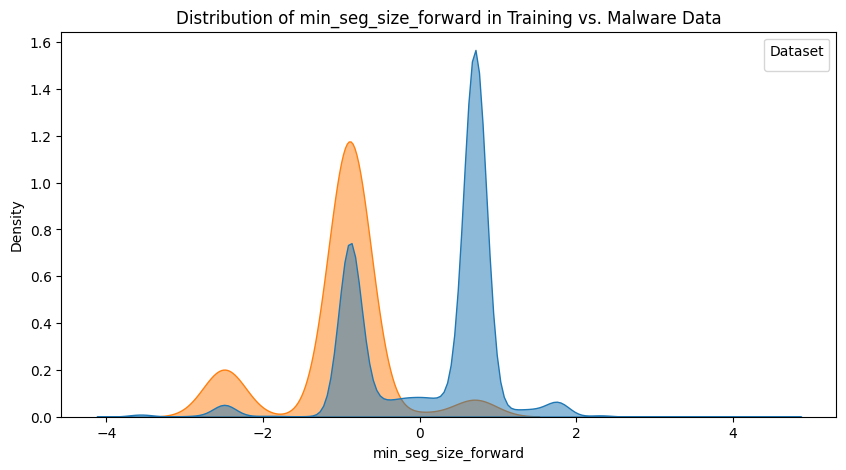

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


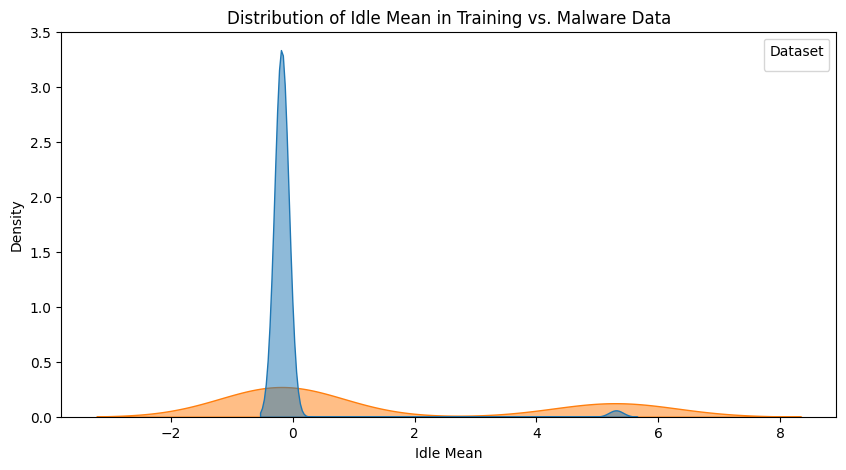

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


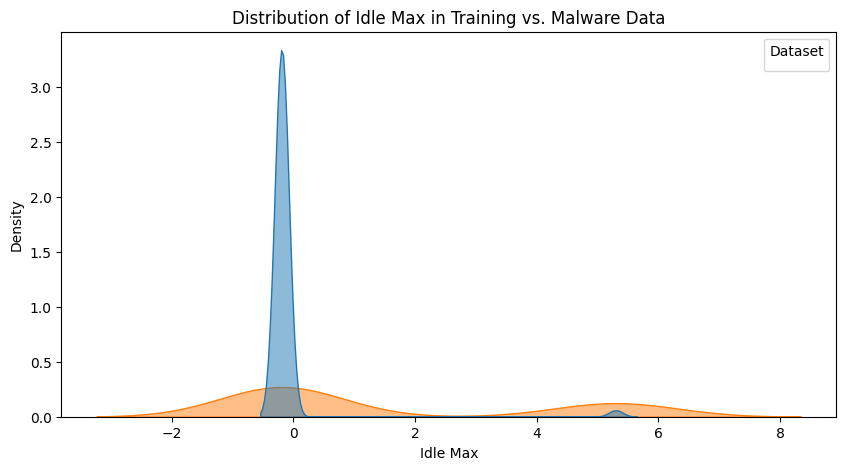

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


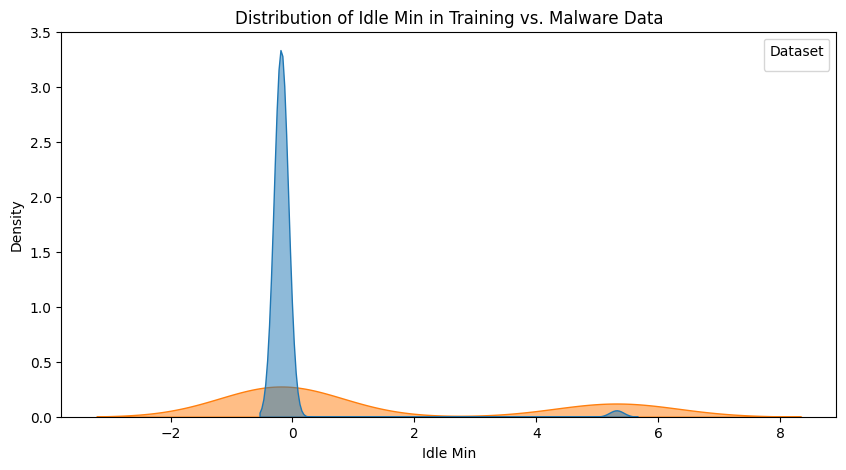


Performing Anomaly Detection using Isolation Forest...

Anomaly Detection Results:
Anomaly
Normal     70
Anomaly    32
Name: count, dtype: int64

Number of anomalies detected: 32

Sample anomalies detected:
                          Flow ID Source IP Source Port Destination IP  \
6   10.0.0.3-10.0.0.4-49830-443-6  10.0.0.3       49830       10.0.0.4   
13  10.0.0.3-10.0.0.4-49834-443-6  10.0.0.3       49834       10.0.0.4   
32  10.0.0.3-10.0.0.4-49846-443-6  10.0.0.3       49846       10.0.0.4   
43  10.0.0.3-10.0.0.4-49852-443-6  10.0.0.3       49852       10.0.0.4   
50  10.0.0.3-10.0.0.4-49856-443-6  10.0.0.3       49856       10.0.0.4   

   Destination Port Protocol               Timestamp Flow Duration  \
6               443        6  14/10/2024 12:50:26 AM        103775   
13              443        6  14/10/2024 12:50:26 AM        123213   
32              443        6  14/10/2024 12:51:03 AM         44911   
43              443        6  14/10/2024 12:51:03 AM         58206 

In [21]:
# Step 11: Load and preprocess malware data
print("\nLoading and preprocessing malware data...")
malware_data_path = "/home/ubuntu/Downloads/Aftermalware.pcap_ISCX.csv"  # Replace with your malware data path
malware_df = pd.read_csv(malware_data_path)

# Identify and Remove Duplicate Flow IDs in malware data
duplicate_flow_ids = malware_df[malware_df.duplicated(subset='Flow ID', keep=False)]['Flow ID'].unique()
malware_df = malware_df[~malware_df['Flow ID'].isin(duplicate_flow_ids)]

print(f"Malware Data - Total Rows After Removal: {len(malware_df)}")
print(malware_df.head())

# Apply the column mapping
malware_df.rename(columns=column_mapping, inplace=True)

# Add missing columns with NaN values
for col in expected_columns:
    if col not in malware_df.columns:
        malware_df[col] = pd.NA
malware_df = malware_df[expected_columns]

# Verify the alignment
print(f"Aligned malware_df Columns:\n{malware_df.columns}")
print(f"Number of Columns: {len(malware_df.columns)}")

# Align column names
malware_df.columns = malware_df.columns.str.strip()

# Use only common columns for consistency
common_columns = list(set(train_columns).intersection(malware_df.columns))
X_malware = malware_df[common_columns].drop(columns=["Class"], errors='ignore')

# Convert data to numeric and handle missing values
X_malware_numeric = X_malware.apply(pd.to_numeric, errors='coerce')
X_malware_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure columns match training columns
X_malware_numeric = X_malware_numeric[train_columns]

# Impute and scale using the existing transformers
X_malware_imputed = imputer.transform(X_malware_numeric)
X_malware_scaled = scaler.transform(X_malware_imputed)
X_malware_selected = selector.transform(X_malware_scaled)

# Step 12: Make predictions on malware data
print("\nMaking predictions on malware data...")
if hasattr(best_model, "predict_proba"):
    y_malware_proba = best_model.predict_proba(X_malware_selected)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores_malware = best_model.decision_function(X_malware_selected)
    from scipy.special import expit
    y_malware_proba = expit(y_scores_malware)
else:
    y_malware_proba = None
    y_malware_pred = best_model.predict(X_malware_selected)

# Experiment with different thresholds
if y_malware_proba is not None:
    thresholds_to_try = [optimal_threshold, 0.4, 0.3, 0.2,0.1]
    for thresh in thresholds_to_try:
        y_malware_pred = (y_malware_proba >= thresh).astype(int)
        malware_df['Predicted Label'] = y_malware_pred
        malware_df['Predicted Label'] = malware_df['Predicted Label'].apply(lambda x: 'Trojan' if x == 1 else 'Benign')
        print(f"\nThreshold: {thresh}")
        print(malware_df['Predicted Label'].value_counts())
else:
    # For models without probability estimates
    malware_df['Predicted Label'] = y_malware_pred
    malware_df['Predicted Label'] = malware_df['Predicted Label'].apply(lambda x: 'Trojan' if x == 1 else 'Benign')
    print("\nPredictions on malware data completed.")
    print("\nPrediction Summary:")
    print(malware_df['Predicted Label'].value_counts())

print("\nAnalyzing Feature Distributions between Training and Malware Data...")

# Prepare data for visualization
X_train_df = pd.DataFrame(X_train_selected, columns=selected_features)
X_train_df['Dataset'] = 'Training Data'

X_malware_df = pd.DataFrame(X_malware_selected, columns=selected_features)
X_malware_df['Dataset'] = 'Malware Data'

combined_df = pd.concat([X_train_df, X_malware_df], ignore_index=True)

# Visualize feature distributions
import matplotlib.pyplot as plt
import seaborn as sns

for feature in selected_features:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(
        data=combined_df,
        x=feature,
        hue='Dataset',
        common_norm=False,
        fill=True,
        alpha=0.5
    )
    plt.title(f'Distribution of {feature} in Training vs. Malware Data')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(title='Dataset')
    plt.show()

# Step 14: Anomaly Detection with Isolation Forest

print("\nPerforming Anomaly Detection using Isolation Forest...")

from sklearn.ensemble import IsolationForest

# Train Isolation Forest on training data
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)
iso_forest.fit(X_train_selected)

# Predict anomalies in malware data
y_malware_anomaly = iso_forest.predict(X_malware_selected)
malware_df['Anomaly'] = y_malware_anomaly
malware_df['Anomaly'] = malware_df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Display anomaly counts
print("\nAnomaly Detection Results:")
print(malware_df['Anomaly'].value_counts())

# Analyze anomalies
anomalies = malware_df[malware_df['Anomaly'] == 'Anomaly']
print(f"\nNumber of anomalies detected: {len(anomalies)}")
print("\nSample anomalies detected:")
print(anomalies.head())


# Save the malware predictions to a CSV file
malware_df.to_csv('malware_predictions.csv', index=False)
print("\nMalware predictions saved as 'malware_predictions.csv'.")